# Imports

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.nn import DataParallel
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random

from pytorch_segmentation.data.train_dataset import TrainDataset
from pytorch_segmentation.data.inmemory_dataset import InMemorySatDataset
from pytorch_segmentation.train_net import train
from pytorch_segmentation.models import UNet
from pytorch_segmentation.losses.dice import DiceLoss
from pytorch_segmentation.losses.tversky import TverskyLoss
from pytorch_segmentation.losses.dice_V2 import FocalTversky_loss
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
cfg = {
    #SA high resoluted data
    "shape_path_sa_high": "data/datasets/V27/data_pool/SA_tree_shapes/labels.geojson",
    "train_data_path_sa_high": "data/datasets/V27/train/SA",
    "val_data_path_sa_high": "data/datasets/V27/val/SA",
    "test_data_path_sa_high": "data/datasets/V27/test/SA",
    
    
    #Rwanda data 2008
    "shape_path_rw_2008": "data/datasets/V27/data_pool/rwanda_tree_shapes/Training_Data_manual_Trial29_V9_2008.shp",
    "train_data_path_rw_2008": "data/datasets/V27/train/rwanda_2008",
    "val_data_path_rw_2008": "data/datasets/V27/val/rwanda_2008",
    "test_data_path_rw_2008": "data/datasets/V27/test/rwanda_2008",

    #Rwanda data 2019
    "shape_path_rw_2019": "data/datasets/V27/data_pool/rwanda_tree_shapes/Training_Data_manual_Trial29_V9_2020.shp",
    "train_data_path_rw_2019": "data/datasets/V27/train/rwanda_2019",
    "val_data_path_rw_2019": "data/datasets/V27/val/rwanda_2019",
    "test_data_path_rw_2019": "data/datasets/V27/test/rwanda_2019",


    "tensorboard_path": "/home/jovyan/work/notebooks/runs",

    # patch_size = [364,364,3]# [x,y,bands]
    # overlap = 300

    # patch_size = [321,321,3]# [x,y,bands]
    # overlap = 270


    "patch_size": [300,300],# [x,y,bands]
    "overlap": 260,

    "val_patch_size": [256,256],# [x,y,bands]
    "val_overlap": 200,

    "test_patch_size": [256,256],
    "overlap_test": 128,

    "padding": False,#True

    "epochs": 500,#25

    "early_stopping": None,

    "dropout": True,

    "scheduler": False,
    "scheduler_warmup": 20,#10
    "sched_step": 15,
    "sched_gamma": 0.1,

    #batch_size = 200
    #batch_size = 50
    "batch_size": 85, #50 #150 #75

    "lr": 3e-4, #1e-3,
    "weight_decay": 1e-4, #1e-3,

    "weighted": True,
    "weight": 0.1,
    "sampler_replacement": True,

    "metric": "iou",

    "n_channels": 3,

    "nworkers": 4,
    "pin_memory": True,

    "nimgs": 4,
    
    "loss_fn": nn.CrossEntropyLoss() #TverskyLoss(0.3,0.7) 
}

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

save_dir = "saved_models"




transform_sa_high = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(0.5,1)), #scale=(0.5,1)
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=1),
    seg_transforms.CenterCrop(256)
])

transform_sa_low = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(1,1)), #scale=(0.5,1)
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=1),
    seg_transforms.CenterCrop(256)
])

transform_rw_2008 = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(0.5,1)), #scale=(0.5,1)
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=1),
    seg_transforms.CenterCrop(256)
])


transform_rw_2019 = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(1,1)), #scale=(1,1)
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.3),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=1),
    seg_transforms.CenterCrop(256)
])




val_transform = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    # seg_transforms.RandomHorizontalFlip(0.5),
    # seg_transforms.RandomVerticalFlip(0.5),
    #seg_transforms.UnmaskEdges([225,225])
#         seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349])
])

test_transform = None


# 1.1 Data Collection

#### Create Training and Test Dataset - SA high

In [4]:
train_dataset_sa_high = TrainDataset(dataset_path=None,data_file_path=cfg["train_data_path_sa_high"],
                   shape_path=cfg["shape_path_sa_high"],
                             overlap=cfg["overlap"],patch_size=cfg["patch_size"],padding=cfg["padding"],transform=transform_sa_high)
val_dataset_sa_high = TrainDataset(dataset_path=None,data_file_path=cfg["val_data_path_sa_high"],
                   shape_path=cfg["shape_path_sa_high"],
                             overlap=cfg["val_overlap"],patch_size=cfg["val_patch_size"],padding=cfg["padding"],transform=val_transform)

# train_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_train,
#                              overlap=overlap,patch_size=patch_size,padding=padding,transform=transform)
# val_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_val,
#                              overlap=val_overlap,patch_size=val_patch_size,padding=padding,transform=val_transform)
# # test_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_test,
#                              overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)


print("Len Train: ",len(train_dataset_sa_high))
print("Len Val: ",len(val_dataset_sa_high))
#print("Len Test: ",len(test_dataset_sa))

100%|██████████| 51/51 [00:15<00:00,  3.40it/s]


Len Train:  57392
Len Val:  11959


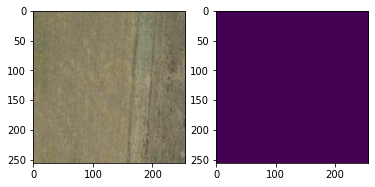

In [5]:
train_dataset_sa_high.show_tuple(958)

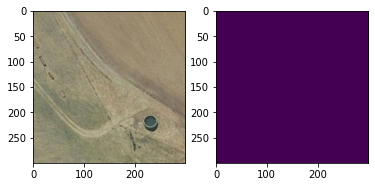

In [6]:
train_dataset_sa_high.show_tuple(315,transform=False)

#### Create Training and Test Dataset - Rwanda 2008

In [7]:
train_dataset_rw_2008 = TrainDataset(dataset_path=None,data_file_path=cfg["train_data_path_rw_2008"],
                   shape_path=cfg["shape_path_rw_2008"],
                             overlap=cfg["overlap"],patch_size=cfg["patch_size"],padding=cfg["padding"],transform=transform_rw_2008)
val_dataset_rw_2008 = TrainDataset(dataset_path=None,data_file_path=cfg["val_data_path_rw_2008"],
                   shape_path=cfg["shape_path_rw_2008"],
                             overlap=cfg["val_overlap"],patch_size=cfg["val_patch_size"],padding=cfg["padding"],transform=val_transform)
# test_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=test_data_path_rw,
#                    shape_path=shape_path_rw, overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)

print("Len Train: ",len(train_dataset_rw_2008))
print("Len Val: ",len(val_dataset_rw_2008))
#print("Len Test: ",len(test_dataset_rw))

 81%|████████  | 77/95 [00:56<00:15,  1.17it/s]

Shape data/datasets/V27/train/rwanda_2008/image_29_4ESE1R.tif.tif is too small for patch size with size: (3, 258, 451)


100%|██████████| 33/33 [00:24<00:00,  1.32it/s]


Len Train:  46723
Len Val:  8956


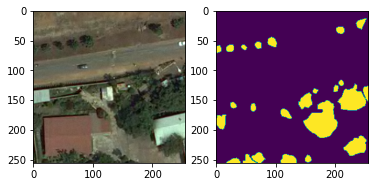

In [8]:
train_dataset_rw_2008.show_tuple(500)

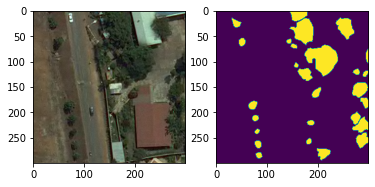

In [9]:
train_dataset_rw_2008.show_tuple(500,transform=False)

#### Create Training and Test Dataset - Rwanda 2019

In [10]:
train_dataset_rw_2019 = TrainDataset(dataset_path=None,data_file_path=cfg["train_data_path_rw_2019"],
                   shape_path=cfg["shape_path_rw_2019"],
                             overlap=cfg["overlap"],patch_size=cfg["patch_size"],padding=cfg["padding"],transform=transform_rw_2019)
val_dataset_rw_2019 = TrainDataset(dataset_path=None,data_file_path=cfg["val_data_path_rw_2019"],
                   shape_path=cfg["shape_path_rw_2019"],
                             overlap=cfg["val_overlap"],patch_size=cfg["val_patch_size"],padding=cfg["padding"],transform=val_transform)
# test_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=test_data_path_rw,
#                    shape_path=shape_path_rw, overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)

print("Len Train: ",len(train_dataset_rw_2019))
print("Len Val: ",len(val_dataset_rw_2019))
#print("Len Test: ",len(test_dataset_rw))

 30%|███       | 16/53 [00:06<00:13,  2.76it/s]

Shape data/datasets/V27/train/rwanda_2019/image_370_19.tif is too small for patch size with size: (3, 216, 602)


100%|██████████| 21/21 [00:12<00:00,  1.62it/s]


Len Train:  26796
Len Val:  5004


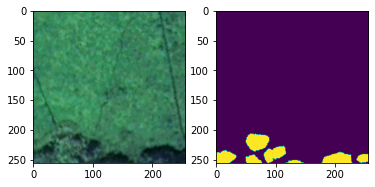

In [11]:
train_dataset_rw_2019.show_tuple(500)

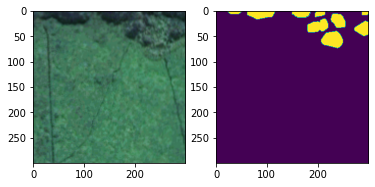

In [12]:
train_dataset_rw_2019.show_tuple(500,transform=False)

# 2. Model Training


In [13]:
from pytorch_segmentation.utils.sampling import create_weighted_dataset

train_dataset,weights = create_weighted_dataset([train_dataset_sa_high,train_dataset_rw_2008,train_dataset_rw_2019],weight=cfg["weight"])

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=cfg["sampler_replacement"]) 

val_dataset = torch.utils.data.ConcatDataset([val_dataset_rw_2008,val_dataset_rw_2019, val_dataset_sa_high])
#test_dataset = torch.utils.data.ConcatDataset([test_dataset_rw, test_dataset_sa])

In [14]:
if cfg["weighted"]:
    train_dl =DataLoader(train_dataset,sampler=sampler,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],shuffle=False,pin_memory=cfg["pin_memory"],
                      drop_last=True)
else:
    train_dl =DataLoader(train_dataset,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],shuffle=True,pin_memory=cfg["pin_memory"],
                  drop_last=True)

if (len(val_dataset) % cfg["batch_size"]) < cfg["nimgs"]:
    val_dl = DataLoader(val_dataset,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],
                     shuffle=True,pin_memory=cfg["pin_memory"],drop_last=True)
else:
    val_dl = DataLoader(val_dataset,batch_size=cfg["batch_size"],num_workers=cfg["nworkers"],
                         shuffle=True,pin_memory=cfg["pin_memory"],drop_last=False)
# test_dl = DataLoader(test_dataset,batch_size=batch_size,num_workers=nworkers,
#                      shuffle=False,pin_memory=pin_memory,drop_last=False)

## 2.2 Advanced Unet 
https://github.com/milesial/Pytorch-UNet

In [15]:
model_path = save_dir+"/unet_"+str(time.strftime("%d_%m_%Y_%H%M%S"))
# Change here to adapt to your data
net = UNet(n_channels=3, n_classes=2, bilinear=False,dropout=cfg["dropout"])

#net= DataParallel(net,device_ids=[1,2])

net = net.to(device=device)


In [16]:
opt = torch.optim.Adam(net.parameters(),lr=cfg["lr"])
#opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)
if cfg["scheduler"]:
    scheduler = torch.optim.lr_scheduler.StepLR(opt, cfg["sched_step"],gamma=cfg["sched_gamma"]) #ReduceLROnPlateau(opt, 'max', patience=2) #S
else: 
    scheduler = None

In [ ]:
train_loss,valid_loss = train(net,train_dl,val_dl,cfg["loss_fn"],opt,cfg["epochs"],model_path=model_path+".pth",scheduler=scheduler,
                              scheduler_warmup=cfg["scheduler_warmup"],early_stopping=cfg["early_stopping"],
                              metric=cfg["metric"],tensorboard_path=cfg["tensorboard_path"],nimgs=cfg["nimgs"],figsize=(16,14),cfg=cfg,device=device,seed=seed)

INFO: Start run for unet_12_12_2022_094645!
Epoch 0/499
----------
train Loss: 0.2776 iou: 0.3982353158401981
valid Loss: 0.1489 iou: 0.5968065921403618
Epoch 1/499
----------
train Loss: 0.2213 iou: 0.4826483799744364
valid Loss: 0.1386 iou: 0.62856944083404
Epoch 2/499
----------
train Loss: 0.2037 iou: 0.5164017052061868
valid Loss: 0.1367 iou: 0.6438712344522751
Epoch 3/499
----------
train Loss: 0.1895 iou: 0.5464562129525342
valid Loss: 0.1349 iou: 0.6791207657500943
Epoch 4/499
----------
train Loss: 0.1815 iou: 0.5677960400753975
valid Loss: 0.1309 iou: 0.6854752548186425
Epoch 5/499
----------
train Loss: 0.1743 iou: 0.5827770363390202
valid Loss: 0.1291 iou: 0.6677205903330787
Epoch 6/499
----------
train Loss: 0.1684 iou: 0.5968819845714042
valid Loss: 0.1298 iou: 0.6893384953956968
Epoch 7/499
----------
train Loss: 0.1631 iou: 0.6082337009738397
valid Loss: 0.1320 iou: 0.6959830979845757
Epoch 8/499
----------
train Loss: 0.1578 iou: 0.6191185095095288
valid Loss: 0.1242 i